### Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Вам предстоит изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

**Описание данных**

В вашем распоряжении три датасета. Файл *visits_info_short.csv* хранит лог сервера с информацией о посещениях сайта, *orders_info_short.csv* — информацию о заказах, а *costs_info_short.csv* — информацию о расходах на рекламу.

Структура *visits_info_short.csv*:
- *User Id* — уникальный идентификатор пользователя,
- *Region* — страна пользователя,
- *Device* — тип устройства пользователя,
- *Channel* — идентификатор источника перехода,
- *Session Start* — дата и время начала сессии,
- *Session End* — дата и время окончания сессии.

Структура *orders_info_short.csv*:
- *User Id* — уникальный идентификатор пользователя,
- *Event Dt* — дата и время покупки,
- *Revenue* — сумма заказа.

Структура *costs_info_short.csv*:
- *dt* — дата проведения рекламной кампании,
- *Channel* — идентификатор рекламного источника,
- *costs* — расходы на эту кампанию.

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

Импортируем нужные библиотеки, загрузим данные

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import math

visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'),  # журнал визитов
    pd.read_csv('/datasets/orders_info.csv'),  # заказы
    pd.read_csv('/datasets/costs_info.csv')  # расходы
)

Посмотрим на данные

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


Имеем три выгрузки из развлекательного приложения Procrastinate Pro+. Задача — разобраться в причинах убытков компании и помочь компании выйти в плюс. Имеем данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Первое, что видим - даты в датафреймах в виде строк, поэтому переведем их в даты.

Преобразование данных о времени

In [4]:
visits['Session Start'] = pd.to_datetime(visits['Session Start'], format="%d.%m.%Y %H:%M")
visits['Session End'] = pd.to_datetime(visits['Session End'], format="%d.%m.%Y %H:%M")

Регион, устройство и канал приведем к строковому типу

In [5]:
visits['Region'] = visits['Region'].astype(str)
visits['Device'] = visits['Device'].astype(str)
visits['Channel'] = visits['Channel'].astype(str)

Переименуем названия столбцов для удобства и для последующего использования в функциях

In [6]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]

Преобразование данных о времени

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Проверим данные на корректность. Для этого воспользуемся методом describe() для численных строк и методами .unique()/.value_counts() для категориальных данных.

In [8]:
visits['user_id'].value_counts()

33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
350468480225     1
748123264144     1
909267360937     1
816252757222     1
425788122907     1
Name: user_id, Length: 150008, dtype: int64

Уникальных пользователей у нас 150008. Самый частотный пользователь мелькал в наших логах 46 раз)

In [9]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

Имеются данные о пользователях из 4х стран - США, Англии, Франции, Германии.

In [10]:
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

Среди данных об устройствах в логах представлены iPhone, Android, PC, Mac. Больше всего в логах пользователей iPhone (112603).

In [11]:
visits['session_start'].count()

309901

In [12]:
visits['session_start'].value_counts()

2019-09-19 12:10:00    9
2019-07-09 10:59:00    8
2019-08-24 18:51:00    8
2019-10-06 18:08:00    8
2019-10-04 23:27:00    8
                      ..
2019-08-24 09:43:00    1
2019-06-17 09:33:00    1
2019-05-18 20:58:00    1
2019-09-02 08:43:00    1
2019-07-23 04:19:00    1
Name: session_start, Length: 180519, dtype: int64

In [13]:
visits['session_end'].value_counts()

2019-10-27 16:09:00    10
2019-10-04 12:55:00     9
2019-10-08 18:07:00     9
2019-07-05 19:29:00     8
2019-09-24 15:42:00     8
                       ..
2019-07-26 04:39:00     1
2019-06-26 16:04:00     1
2019-08-04 03:39:00     1
2019-08-22 01:39:00     1
2019-08-17 15:40:00     1
Name: session_end, Length: 180778, dtype: int64

In [14]:
visits['session_end'].count()

309901

И 180778 уникальных записей с информацией о конце сессии. Всего записей также 309901.

In [15]:
visits[visits.duplicated()]

,user_id,region,device,channel,session_start,session_end


Дубликатов строк нет.

Перейдем к данным о заказах.

In [16]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [18]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'], format="%Y-%m-%d %H:%M:%S")

Переименуем названия столбцов для удобства и для последующего использования в функциях

In [19]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]

Преобразование данных о времени

In [20]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Посмотрим на нулевые значения

In [21]:
pd.DataFrame(round((orders.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
user_id,0.000000
event_dt,0.000000
revenue,0.000000


Нулевых значений нет.

Пробежимся по данным и проверим их на корректность. Для этого воспользуемся методом describe() для численных строк и методами .unique()/.value_counts() для категориальных данных.

In [22]:
orders['user_id'].value_counts()

901180916748    22
883098437811    20
75337957494     19
512471511263    19
295795879965    19
                ..
237296010927     1
319939546352     1
742075710598     1
202972423389     1
775233404832     1
Name: user_id, Length: 8881, dtype: int64

В логах о заказах у нас присутствует 8881 уникальный пользователь, самый часто заказывающий - пользователь с user_id 901180916748.

In [23]:
orders['event_dt'].value_counts()

2019-09-29 09:03:24    2
2019-10-25 16:24:24    2
2019-09-27 03:56:55    2
2019-08-12 22:50:49    2
2019-09-09 20:01:39    2
                      ..
2019-09-26 04:24:10    1
2019-10-26 06:25:45    1
2019-07-10 17:04:38    1
2019-08-06 08:55:42    1
2019-09-25 16:41:33    1
Name: event_dt, Length: 40163, dtype: int64

In [24]:
orders['event_dt'].count()

40212

Всего 40212 строк с информацией о заказах. Из них 40163 с уникальным 'event_dt'.

In [25]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

В среднем каждый заказ совершается на сумму 5.37 у.е. Медиана и среднее довольно близко расположены, можно предположить, что сильных выбрососв в данных нет. Также видим, что 1, 2, 3 и 4 квантили - все они равны 4.99. Можно предположить, что это стоимость подписки.

Проверим данные на наличие дубликатов

In [26]:
orders[orders.duplicated()]

,user_id,event_dt,revenue


Дубликатов строк нет.

Перейдем к данным о рекламных тратах.

In [27]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [28]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Преобразование данных о времени

In [29]:
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

Канал приведем к строковому типу

In [30]:
costs['Channel'] = costs['Channel'].astype('str')

Переименуем названия столбцов для удобства и для последующего использования в функциях

In [31]:
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

Пробежимся по данным и проверим их на корректность. Для этого воспользуемся методом describe() для численных строк и методами .unique()/.value_counts() для категориальных данных.

In [32]:
costs['dt'].value_counts()

2019-10-10    10
2019-06-01    10
2019-08-30    10
2019-10-14    10
2019-06-12    10
              ..
2019-05-24    10
2019-07-08    10
2019-08-22    10
2019-10-06    10
2019-08-26    10
Name: dt, Length: 180, dtype: int64

In [33]:
costs['dt'].count()

1800

In [34]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

В выгрузке представлены данные по закупкам в 10 каналах - 'FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit', 'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner', 'lambdaMediaAds'

In [35]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

Cредние и медианные затраты на маркетинг разнятся (58.6 и 12.2 соответственно) - возможно, что на какие-то каналы уходит бльше трат, на какие-то меньше. Максимальная трата на маркетинг - 630 у.е., минимальные - 0.8.

Проверим данные на наличие дубликатов

In [36]:
costs[costs.duplicated()]

,dt,channel,costs


Дубликатов не обнаружено.

#### Вывод

На данном этапе мы положили данные о визитах, заказах и рекламных тратах в переменные и подготовили данные к анализу. Типы данных во всех колонках, как пологается, соответствуют нужным значениям. Дубликатов не обнаружено.

Уникальных пользователей у нас 150008. Самый частотный пользователь мелькал в наших логах 46 раз) В логах имеются данные о пользователях из 4х стран - США, Англии, Франции, Германии. Среди данных об устройствах в логах представлены iPhone, Android, PC, Mac. Больше всего в логах пользователей iPhone (112603). Всего 180519 уникальных записей с информацией о начале сессии. Всего записей - 309901 И 180778 уникальных записей с информацией о конце сессии. Всего записей также 309901.

В логах о заказах у нас присутствует 8881 уникальный пользователь, самый часто заказывающий - пользователь 901180916748. Всего в выгрузке 40212 строк с информацией о заказах. Из них 40163 с уникальным 'event_dt'. В среднем каждый заказ совершается на сумму 5.37 у.е. Медиана и среднее довольно близко расположены, можно предположить, что сильных выбрососв в данных нет. Также видим, что 1, 2, 3 и 4 квантили - все они равны 4.99.

Всего 1800 строк с данными о затратах на маркетинг. Из них 180 уникальных строк с датами, то есть, в логах собраны данные за 180 дней. В выгрузке представлены данные по закупкам в 10 каналах - 'FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit', 'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner', 'lambdaMediaAds' Средние и медианные затраты на маркетинг разнятся (58.6 и 12.2 соответственно) . Максимальная трата на маркетинг - 630 у.е., минимальные - 0.8.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.


Момент анализа у нас 01.11.2019, а горизонт анализа - 14 дней. Из расчетов нам следует исключить пользователей с органическим трафиком, поскольку мы за них ничего не платим.

In [37]:
import time
from datetime import datetime
from datetime import date, timedelta as td

observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

#### Функция для расчёта удержания

In [38]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для визуализации удержания

In [39]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция для расчёта конверсии

In [40]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для визуализации конверсии

In [41]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция для расчёта LTV и ROI

In [42]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

**Зададим также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().**

#### Функция для сглаживания фрейма

In [43]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для визуализации LTV и ROI

In [44]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

**Вывод**

Заданы основные функции для расчета и анализа удержания, конверсии, LTV и ROI.

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.

Функция для создания пользовательских профилей

In [45]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Получим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу.

Получаем профили пользователей

In [46]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную даты привлечения пользователей.

In [47]:
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()  # момент анализа
print(min_analysis_date, "\n", observation_date)

2019-05-01 00:00:00 
 2019-10-27 00:00:00


##### Вывод

Минимальная дата привлечения пользователей - 1 мая 2019 года. Максимальная дата привлечения пользователей - 27 октября 2019 года. Все корректно, с ТЗ согласуется (выдержка из ТЗ: "Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года")

#### Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

Построим таблицу, отражающую количество пользователей и их долю из каждой страны.

In [48]:
region_share = pd.DataFrame()
region_share['users_cnt'] = profiles.groupby('region')['user_id'].count()
region_share['share'] = ((region_share['users_cnt'] / profiles['region'].count()) * 100)
region_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
region,,
United States,100002,66.66%
UK,17575,11.72%
France,17450,11.63%
Germany,14981,9.99%


Судя по резльтатам, бОльшая доля пользователей - это люди из США (66.66%). Далее идут примерно равные доли пользователей из Англии и Франции (~ 12%). Меньше всего пользователей из Германии (~ 10%).

Теперь посмотрим на платящих пользователей и долю платящих из каждой страны.

In [49]:
region_payer_share = pd.DataFrame()
region_payer_share['users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer_share['share'] = ((region_payer_share['users_cnt'] / profiles.query('payer == True')['region'].count()) * 100)
region_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
region,,
United States,6902,77.72%
UK,700,7.88%
France,663,7.47%
Germany,616,6.94%


Посмотрим профили

In [50]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:00,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:00,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:00,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


Платящие пользователи из США лидируют (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%)

Рассчитаем долю платящих пользователей отдельно по странам.

На вход задаем колонку, в разрезе которой смотрим, и датафрейм-источник

In [51]:
def pivot_share_result(column, df):
    result = pd.DataFrame()
    result['users_cnt'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users_cnt'] / df[column].count()) * 100)
    result['payer_users_cnt'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = ((result['payer_users_cnt'] / result['users_cnt']) * 100)
    return result.sort_values(by='users_share', ascending=False).style.format({'users_share': '{:.2f}%', 'payer_share': '{:.2f}%'})
pivot_share_result('region', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
region,,,,
United States,100002,66.66%,6902,6.90%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%
Germany,14981,9.99%,616,4.11%


##### Вывод

Видим, что доля платящих пользователей из США - 6.90%. Среди пользователей из Англии (17575) платящий сегмент составляет 3.98% (700 человек). Примерно такое же соотношение и для пользователей из Франции (3.80% платящих пользователей). Среди пользователей Германии (14981 человека) 616 человек - платящие (это 4.1%).

#### Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [52]:
device_share = pd.DataFrame()
device_share['users_cnt'] = profiles.groupby('device')['user_id'].count()
device_share['share'] = ((device_share['users_cnt'] / profiles['device'].count()) * 100)
device_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,54479,36.32%
Android,35032,23.35%
PC,30455,20.30%
Mac,30042,20.03%


Судя по таблице, большинство пользователей - это владельцы IPhone (36%) и Android (23%). То есть, клиенты больше пользуются мобильными устройствами, чем ПК. Доли PC и Mac практически одинаковы (по 20%).

Изучим распределение для платящих пользователей.

In [53]:
device_payer_share = pd.DataFrame()
device_payer_share['users_cnt'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer_share['share'] = ((device_payer_share['users_cnt'] / profiles.query('payer == True')['device'].count()) * 100)
device_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%'})

,users_cnt,share
device,,
iPhone,3382,38.08%
Android,2050,23.08%
Mac,1912,21.53%
PC,1537,17.31%


Ситуация для платящих пользователей повторяет общую картину (только MAC и PC поменялись местами). Основная доля платящих пользователей - это владельцы IPhone (38%). Далее идут владельцы Android (23%), Mac(21%) и PC(17%).

Рассчитаем долю платящих пользователей отдельно по устройствам.

In [54]:
pivot_share_result('device', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
device,,,,
iPhone,54479,36.32%,3382,6.21%
Android,35032,23.35%,2050,5.85%
PC,30455,20.30%,1537,5.05%
Mac,30042,20.03%,1912,6.36%


##### Вывод

Больше всего доля платящих пользователей для устройства Mac: 6.36% (1912 человек) из 30042 платят за продукт. Среди пользователей iPhone (54479 человек) доля платящих равна 6.21%. Для пользователей Android (35032 человек) она составляет 5.85%. Среди пользователей PC (30455) платящих меньше всего - 5.05% (1537 человек).

#### Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [55]:
channel_share = pd.DataFrame()
channel_share['users_cnt'] = profiles.groupby('channel')['user_id'].count()
channel_share['share'] = ((channel_share['users_cnt'] / profiles['channel'].count()) * 100)

channel_share['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_share['payer_share'] = ((channel_share['payer_users_cnt'] / profiles.query('payer == True')['channel'].count()) * 100)

channel_share.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,users_cnt,share,payer_users_cnt,payer_share
channel,,,,
organic,56439,37.62%,1160,13.06%
FaceBoom,29144,19.43%,3557,40.05%
TipTop,19561,13.04%,1878,21.15%
OppleCreativeMedia,8605,5.74%,233,2.62%
LeapBob,8553,5.70%,262,2.95%
WahooNetBanner,8553,5.70%,453,5.10%
RocketSuperAds,4448,2.97%,352,3.96%
MediaTornado,4364,2.91%,156,1.76%
YRabbit,4312,2.87%,165,1.86%


Если посмотреть на разбивку по источникам привлечения для всех пользователей (и платящих, и неплатящих), то можно заметить, что больше всего приходится на органический трафик (38%), далее по числу пользователей идут источники FaceBoom (19%) и TipTop(13%).

Для платящего сегмента пользователей картина несколько иная. Большинство платящих пользователей пришли через канал FaceBoom (40%), 21% из TipTop и только 13% - из органического трафика.

По остальным каналам распределение равномерное (в районе 3-5%). Самый непопулярный канал для всех сегментов пользователей - это lambdaMediaAds, для платящих - MediaTornado.

Рассчитаем долю платящих пользователей отдельно по каналам.

Исключим пользователей с органическим трафиком

In [56]:
profiles = profiles.query('channel != "organic"')
pivot_share_result('channel', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
channel,,,,
FaceBoom,29144,31.15%,3557,12.20%
TipTop,19561,20.91%,1878,9.60%
OppleCreativeMedia,8605,9.20%,233,2.71%
LeapBob,8553,9.14%,262,3.06%
WahooNetBanner,8553,9.14%,453,5.30%
RocketSuperAds,4448,4.75%,352,7.91%
MediaTornado,4364,4.66%,156,3.57%
YRabbit,4312,4.61%,165,3.83%
AdNonSense,3880,4.15%,440,11.34%


##### Вывод

Большинство платящих пользователей приходится на каналы FaceBoom (12.20%), AdNonSense(11.34%) и lambdaMediaAds(10.47%). Менее всего конвертируются пользователи из каналов organic (2.06%), OppleCreativeMedia (2.71%) и LeapBob (3.06%).

#### Вывод

На данном этапе были сформированы профили пользователей. Для этого использовалась функция get_profiles(), в которую были переданы данные о посещениях, покупках и тратах на рекламу. Определены минимальная и максимальная даты привлечения пользователей. Это 2019-05-01 00:00:00 и 2019-10-27 00:00:00.

Построена таблица, отражающую количество пользователей и их долю из каждой страны. Судя по резльтатам, бОльшая доля пользователей - это люди из США (66.66%). Далее идут примерно равные доли пользователей из Англии и Франции (~ 12%). Меньше всего пользователей из Германии (~ 10%).

Изучены платящие пользователи и их долю из каждой страны. Платящие пользователи из США лидируют (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%) Также выявлено, что доля платящих пользователей из США - 6.90%. Среди пользователей из Англии (17575) платящий сегмент составляет 3.98% (700 человек). Примерно такое же соотношение и для пользователей из Франции (3.80% платящих пользователей). Среди пользователей Германии (14981 человека) 616 человек - платящие (это 4.1%).

Изучено, какими устройствами пользуются клиенты, и какие устройства предпочитают платящие пользователи. Судя по таблице, большинство пользователей - это владельцы IPhone (36%) и Android (23%). То есть, клиенты больше пользуются мобильными устройствами, чем ПК. Доли PC и Mac практически одинаковы (по 20%).
* Больше всего доля платящих пользователей для устройства Mac: 6.36% (1912 человек) из 30042 платят за продукт.
* Среди пользователей iPhone (54479 человек) доля платящих равна 6.21%. Для пользователей Android (35032 человек) она составляет 5.85%.
* Среди пользователей PC (30455) платящих меньше всего - 5.05% (1537 человек).

Исследованы рекламные источники привлечения и определены каналы, из которых пришло больше всего платящих пользователей. Если посмотреть на разбивку по источникам привлечения для всех пользователей (и платящих, и неплатящих), то можно заметить, что больше всего приходится на органический трафик (38%), далее по числу пользователей идут источники FaceBoom (19%) и TipTop(13%).
* Большинство платящих пользователей приходится на каналы FaceBoom (12.20%), AdNonSense(11.34%) и lambdaMediaAds(10.47%).
* Менее всего конвертируются пользователи из каналов organic (2.06%), OppleCreativeMedia (2.71%) и LeapBob (3.06%).

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Посчитайте общую сумму расходов на маркетинг.

Исползуем для этого таблицу costs

In [57]:
display(costs.sum())

channel    FaceBoomFaceBoomFaceBoomFaceBoomFaceBoomFaceBo...
costs                                               105497.3
dtype: object

In [58]:
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


Построим график изменений расходов на маркетинг

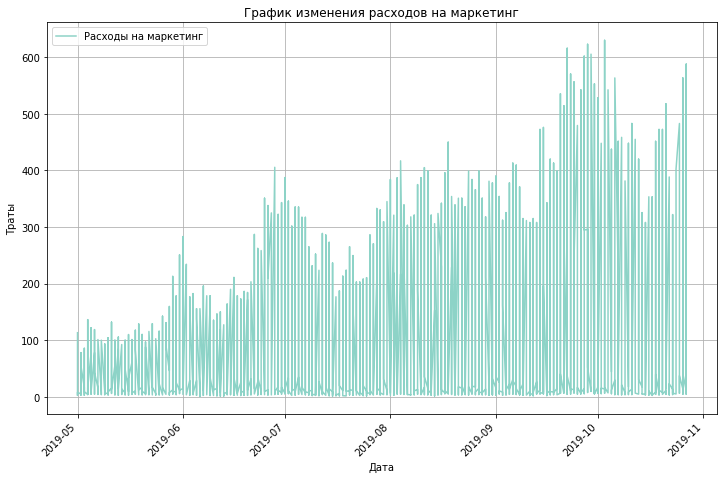

In [59]:
costs.plot(y='costs', # столбец значений для вертикальной оси,
           x='dt',
           figsize=(12, 8), # размеры картинки: (x_size, y_size)
           grid=True, # отображать сетку или нет
           rot=45,        
           label='Расходы на маркетинг', # название линии                       
           legend=True,# выводить ли легенду к графику
           colormap='Set3') 

plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.show()

Видим уведичение расходов на маркетинг с течением времени. В конце сентября - начале октября они достигли исторического пика в 630 у.е., после чего стали немного снижаться до 400, а затем к концу октября внось стремились к 600.

#### Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.ены по источникам.

In [60]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [61]:
channel_costs_report = pd.DataFrame()
channel_costs_report['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs_report['share'] = ((channel_costs_report['costs'] / costs['costs'].sum()) * 100)
channel_costs_report.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})


,costs,share
channel,,
TipTop,54751.300000,51.90%
FaceBoom,32445.600000,30.75%
WahooNetBanner,5151.000000,4.88%
AdNonSense,3911.250000,3.71%
OppleCreativeMedia,2151.250000,2.04%
RocketSuperAds,1833.000000,1.74%
LeapBob,1797.600000,1.70%
lambdaMediaAds,1557.600000,1.48%
MediaTornado,954.480000,0.90%


Больше всего трат приходитя на источник TipTop (51.9%). Следом идет источник FaceBoom(30.75%). Далее идут низкозатратные источники WahooNetBanner (4.88%), AdNonSense (3.71%), OppleCreativeMedia (2.04%). На оставшиеся источники приходится 1-2% трат.

#### Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.

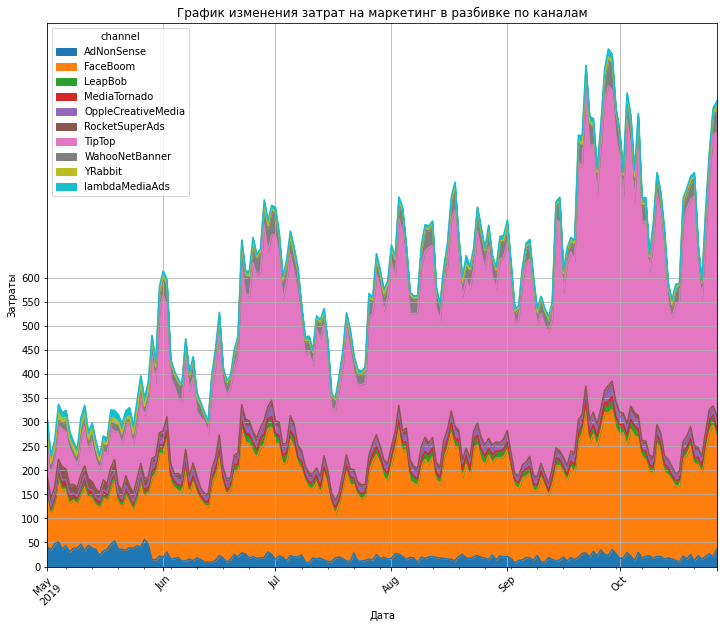

In [62]:
filtered_data = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
ax = filtered_data.plot.area(                                             
           figsize=(12, 10), # размеры картинки: (x_size, y_size)
           grid=True, # отображать сетку или нет
           rot=45,        
           label='Каналы', # название линии                       
           legend=True,# выводить ли легенду к графику
           #colormap='ocean'
) 

plt.yticks(np.arange(0, 650, 50)) #зададим шаг по oy
plt.title('График изменения затрат на маркетинг в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Видим тут двух "активных игроков" - это TipTop и FaceBoom. Больше всего трафика закупали у TipTop и к октябрю число трат приближалось к 650 у.е. Число трат на FaceBoom находится в районе 300. И если остальные источники не показывают какую-либо значительную динамику, то затраты на источник Tip-Top возрастают со временем. Остальные каналы привлечения обходятся довольно дешево

Посмотрим на них в отдельном срезе, чтобы понять динамику, тк в предыдущем графике данные по ним недостаточно показательны.

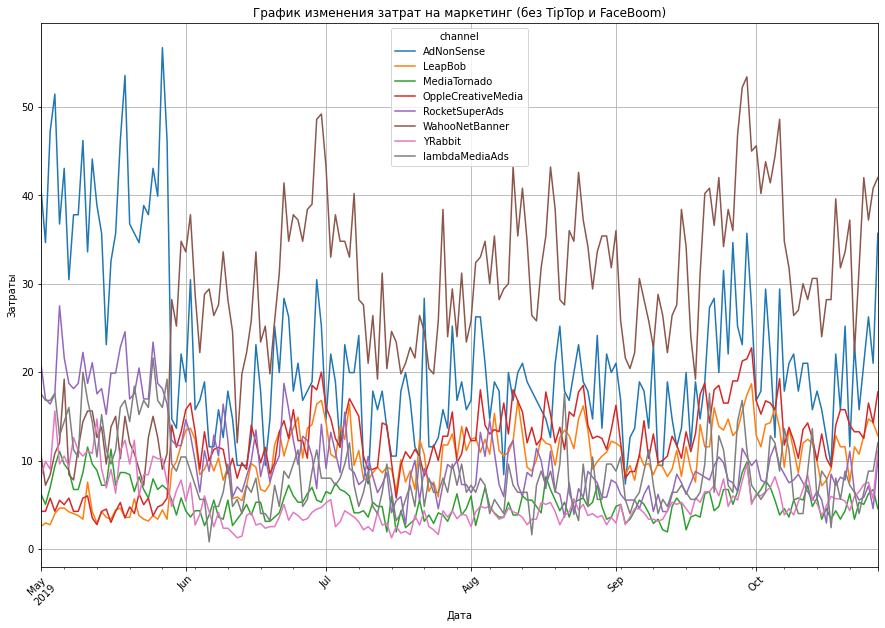

In [63]:
filtered_data2 = costs[~costs['channel'].isin(['TipTop', 'FaceBoom'])].pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )

filtered_data2.plot(                                             
           figsize=(15, 10), # размеры картинки: (x_size, y_size)
           grid=True, # отображать сетку или нет
           rot=45,        
           label='Каналы', # название линии                       
           legend=True,# выводить ли легенду к графику
           #colormap='ocean'
) 

plt.yticks(np.arange(0,  60, 10)) #зададим шаг по oy
plt.title('График изменения затрат на маркетинг (без TipTop и FaceBoom)')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Среди рекламных источников помимо TipTop и FaceBoom с июня начали расти траты на WahooNetBanner (к октябрю их число было в районе 53 у.е.). Затраты на AdNonSense, наоборот, стали снижаться с июня 2019 года (с 55 до 35). По остальным источникам траты варьируются в пределах 3-20 у.е.

#### Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Будем использовать профили пользователей.

In [64]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:00,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000


Информация о стоимости привлечения есть в колонке 'acquisition_cost'.

In [65]:
profiles.describe()

,user_id,acquisition_cost
count,9.356900e+04,93569.000000
mean,4.995116e+11,1.127481
std,2.881600e+11,0.990503
min,5.993260e+05,0.124615
25%,2.506301e+11,0.257143
50%,4.972331e+11,1.080531
75%,7.490889e+11,1.128571
max,9.999799e+11,3.715385


Медианная стоимость привлечения одного пользователя - 0.24. При этом среднее находится на значении 0.7. Вероятно, в какие-то периоды мы тратили на пользователей больше, и в данных есть какие-то выбросы, которые влияют на разницу в стреднем и медианой. Максимальная стоимость привлечения пользователя - 3.71 у.е.

Визуализируем через гистограмму

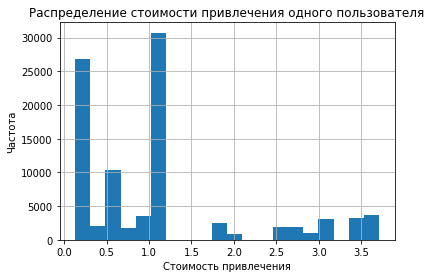

In [66]:
profiles['acquisition_cost'].hist(bins=20)
plt.title('Распределение стоимости привлечения одного пользователя')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Частота')
plt.show()

На разницу между медианой и средним оказывает влияние большое число нулевой стоимости пользователей. Вероятно, это органический трафик.

Посмотрим на CAC для каждого источника трафика.

In [67]:
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самый дорогой трафик - TipTop (средняя стоимость - 2.80 за пользователя), далее идет FaceBoom и AdNonSense примерно в равной ценовой категории (1.11 и 1.01 соответственно). Органический трафик бесплатен, остальные каналы берут за пользователя от 0.21 до 0.72 у.е.

#### Вывод

Всего на маркетинг потрачено 105497.3 у.е.

Выяснено, как траты распределены по источникам. Больше всего трат приходитя на источник TipTop (51.9%). Следом идет источник FaceBoom(30.75%). Далее идут низкозатратные источники WahooNetBanner (4.88%), AdNonSense (3.71%), OppleCreativeMedia (2.04%). На оставшиеся источники приходится 1-2% трат.

Визуализировано изменение метрик во времени. Заметны два "активных игрока" - это TipTop и FaceBoom. Больше всего трафика закупали у TipTop, и к октябрю число трат приближалось к 650 у.е. Число трат на FaceBoom находится в районе 300. Остальные каналы привлечения обходятся довольно дешево.

Среди рекламных источников помимо TipTop и FaceBoom с июня начали расти траты на WahooNetBanner (к октябрю их число было в районе 53 у.е.). Затраты на AdNonSense, наоборот, стали снижаться с июня 2019 года (с 55 до 35). По остальным источникам траты варьируются в пределах 3-20 у.е.

Выяснено, сколько в среднем стоило привлечение одного пользователя из каждого источника.

Рассчитан средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Медианная стоимость привлечения одного пользователя - 0.24. При этом среднее находится на значении 0.7. Вероятно, в какие-то периоды мы тратили на пользователей больше, и в данных есть какие-то выбросы, которые влияют на разницу в стреднем и медианой. Максимальная стоимость привлечения пользователя - 3.71 у.е.

На разницу между медианой и средним оказывает влияние большое число нулевой стоимости пользователей. Вероятно, это органический трафик.

Самый дорогой трафик - TipTop (средняя стоимость - 2.80 за пользователя), далее идет FaceBoom и AdNonSense примерно в равной ценовой категории (1.11 и 1.01 соответственно). Органический трафик бесплатен, остальные каналы берут за пользователя от 0.21 до 0.72 у.е.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

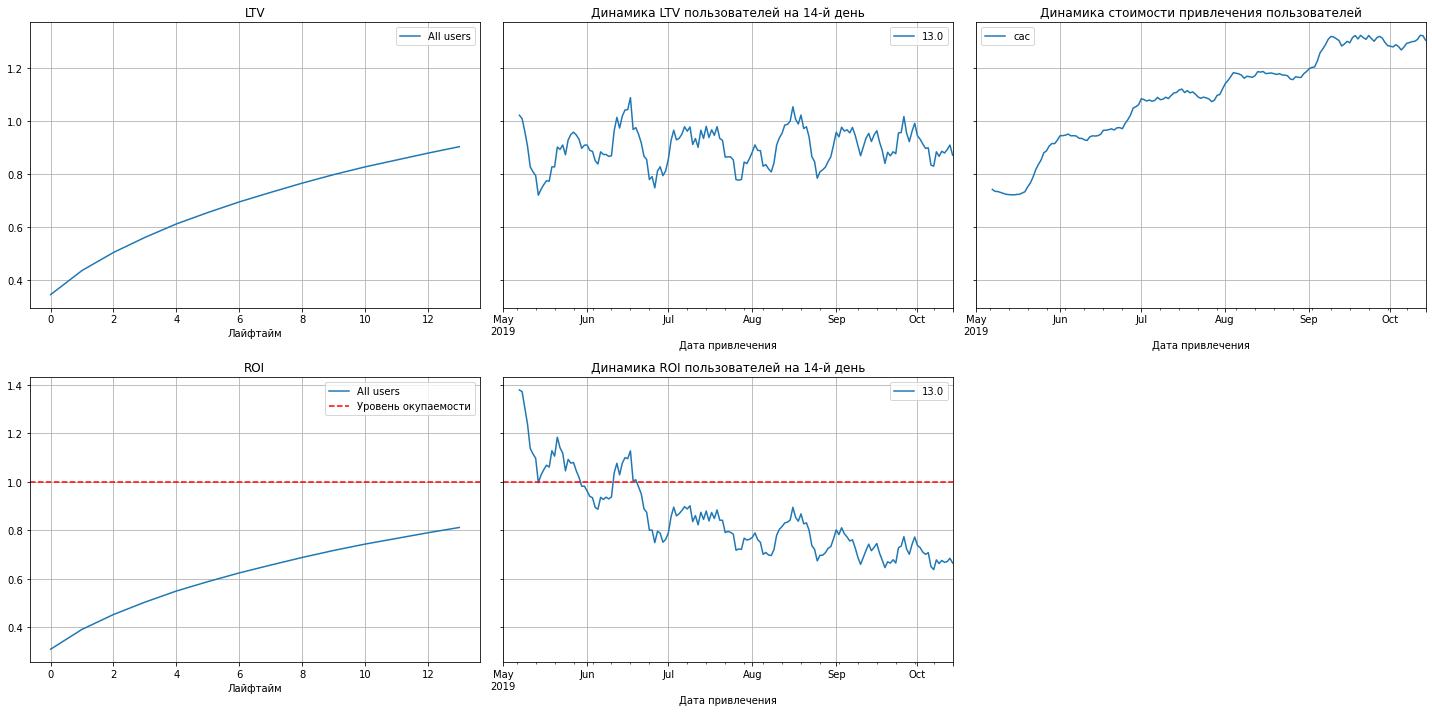

In [68]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:

1. Реклама не окупается к концу 2й недели. ROI — около 80%.
2. CAC нестабилен. Рекламный бюджет увеличивается с течением времени.
3. На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
4. ROI пользователей неумолимо падает. До июля показатель был выше уровня окупаемости, но после стал падать до 0.6.

#### Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

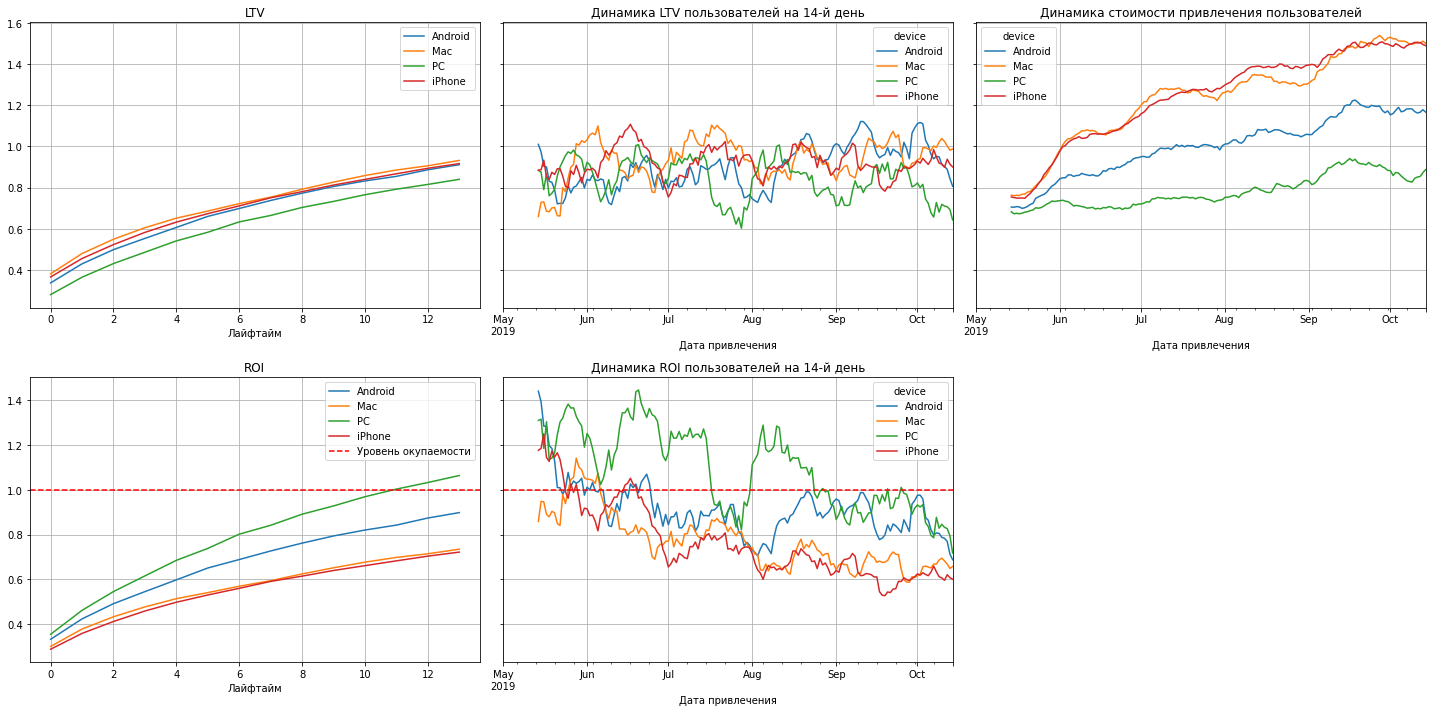

In [69]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Пользователи всех устройств окупались до июня, а потом что-то пошло не так, особенно для владельцев Mac и Iphone. К сентябрю (и какое-то время в августе) ROI пользователей PC на 14 день был на грани окупаемости, ROI всех остальных устройств был уже ниже уровня начиная с июня. LTV пользователей всё так же подвержен сезонности, но стабилен. Стоимость привлечения пользователей PC самая низкая, а ROI - наоборот, выше остальных. В целом, видим, что стоимость привлечения пользователей всех устройств росла за рассматриваемый период.

Направить внимание следует на владельцев Mac и iPhone - стоимость их привлечения высока (и растет от месяца к месяцу), а окупаемоcть страдает.

#### Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

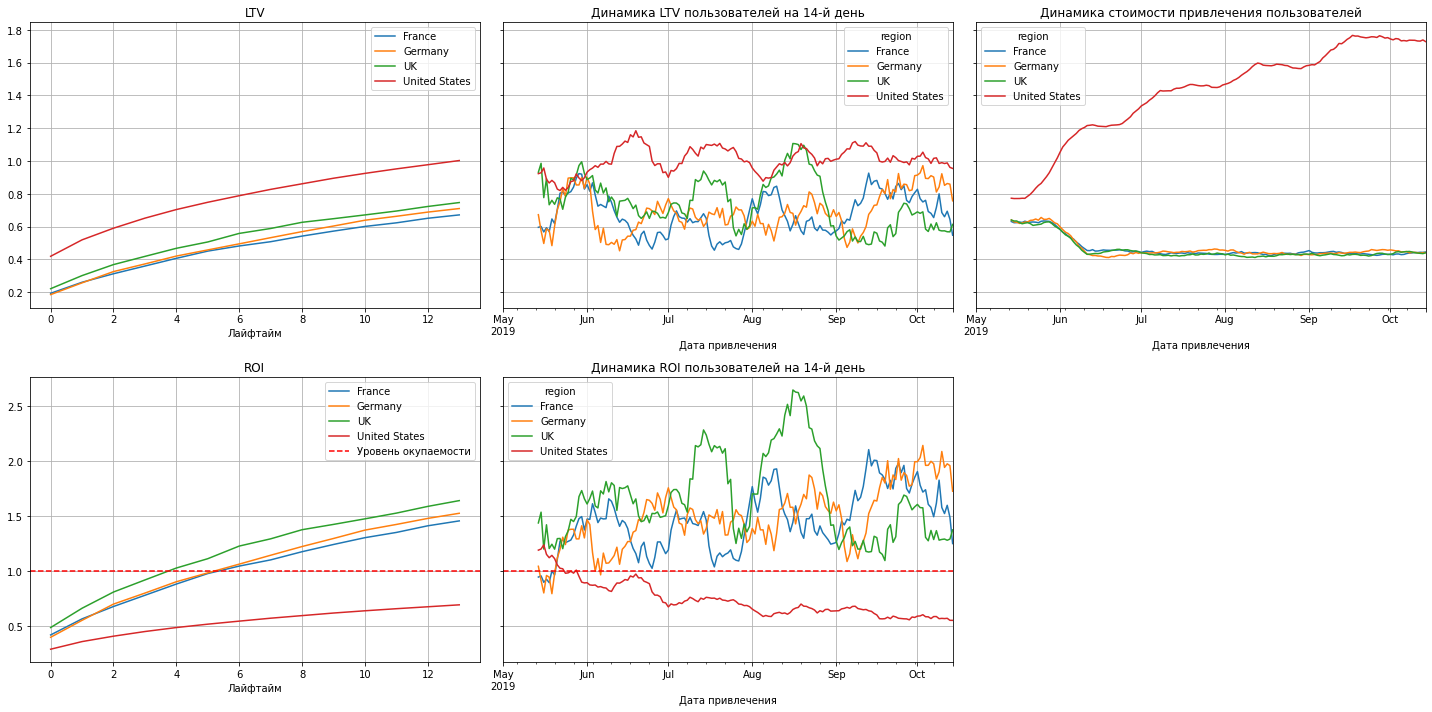

In [70]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Видим:

1. Реклама окупается не везде. В США уровень окупаемости рекламы низкий, а, как мы помним, у нас основная аудитория - это пользователи из США.
2. При этом стоимость привлечения пользователей из Америки - самая высокая. И она растет.
3. LTV всё так же подвержен сезонности, но стабилен.
4. Лучше всего окупается Англия и Германия. Явный аутсайдер - США. Причем окупаемость пользователей начала падать с конца июня 2019 года. Возможно, неудачный релиз, запуск похожего продукта у конкурентов или какие-то изменения в продукте сыграли такую роль, и сервис стал менеее привлекательным для пользователей.

Актентируем внимание на пользователей из США.

#### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

Проверим источники привлечения (channel). Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.

Cмотрим окупаемость с разбивкой по источникам привлечения

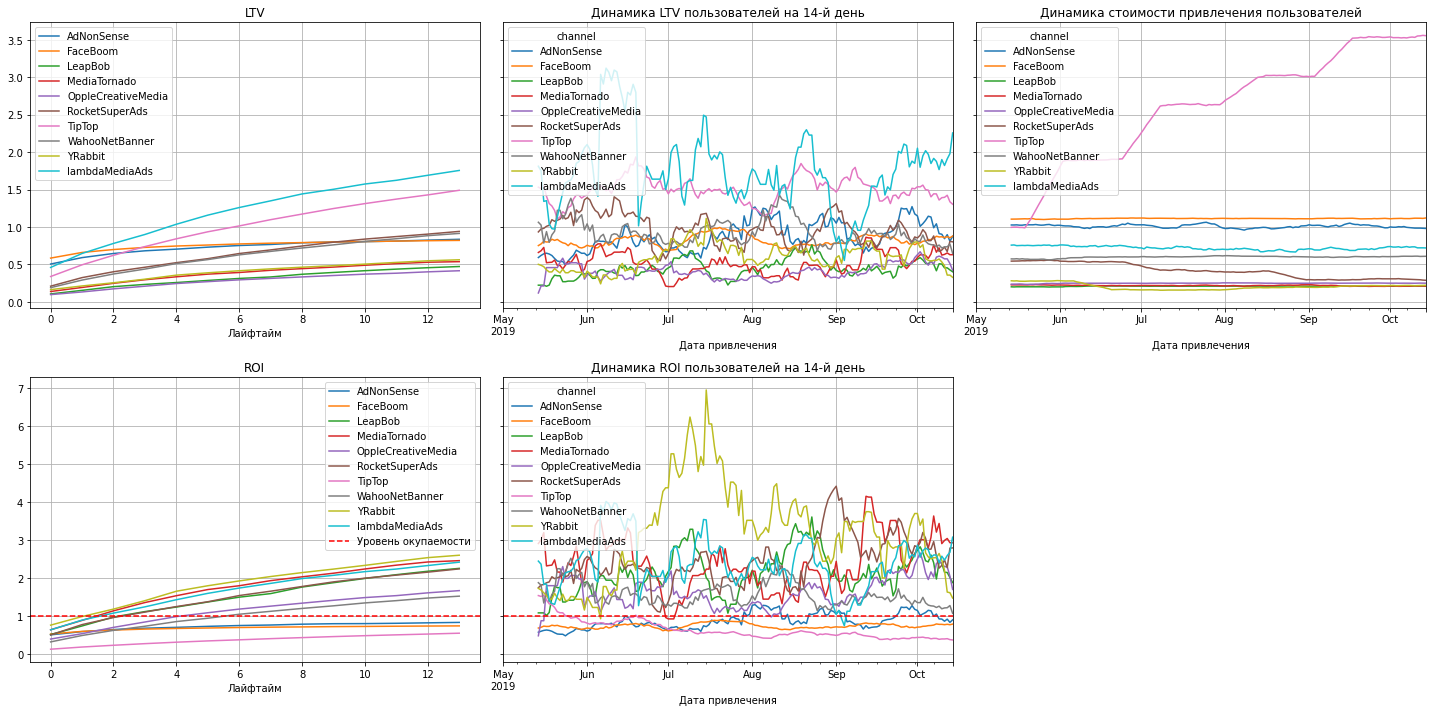

In [71]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Видим большой рост стоимости привлечения пользователей из рекламного канала TipTop. Достаточно много средств было потрачено на эту рекламную сеть,но реальные результаты ниже ожидаемых. Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop. Хорошо показала себя рекламная сеть YRabbit в июле - ROI пользователей на 14 день был высок.

#### Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.

Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion()

**Cмотрим конверсию с разбивкой по устройствам**

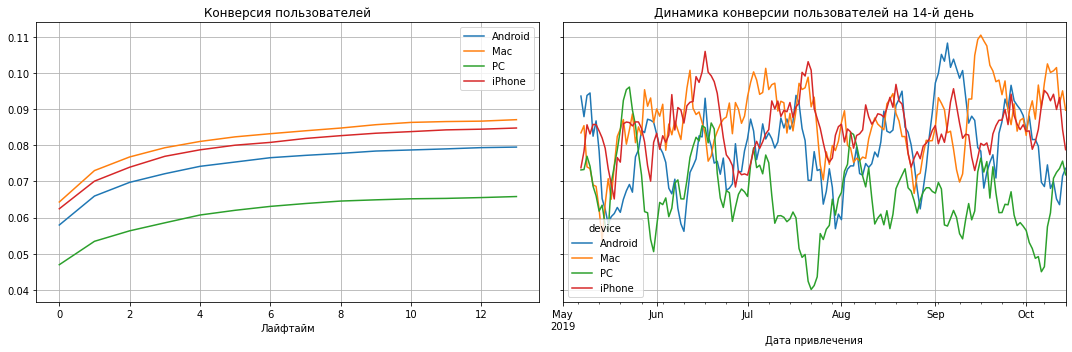

In [72]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи Mac, Android и iPhone конвертируются хорошо, причём постоянно. Видимо, дело в удержании. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

**Cмотрим удержание с разбивкой по устройствам***

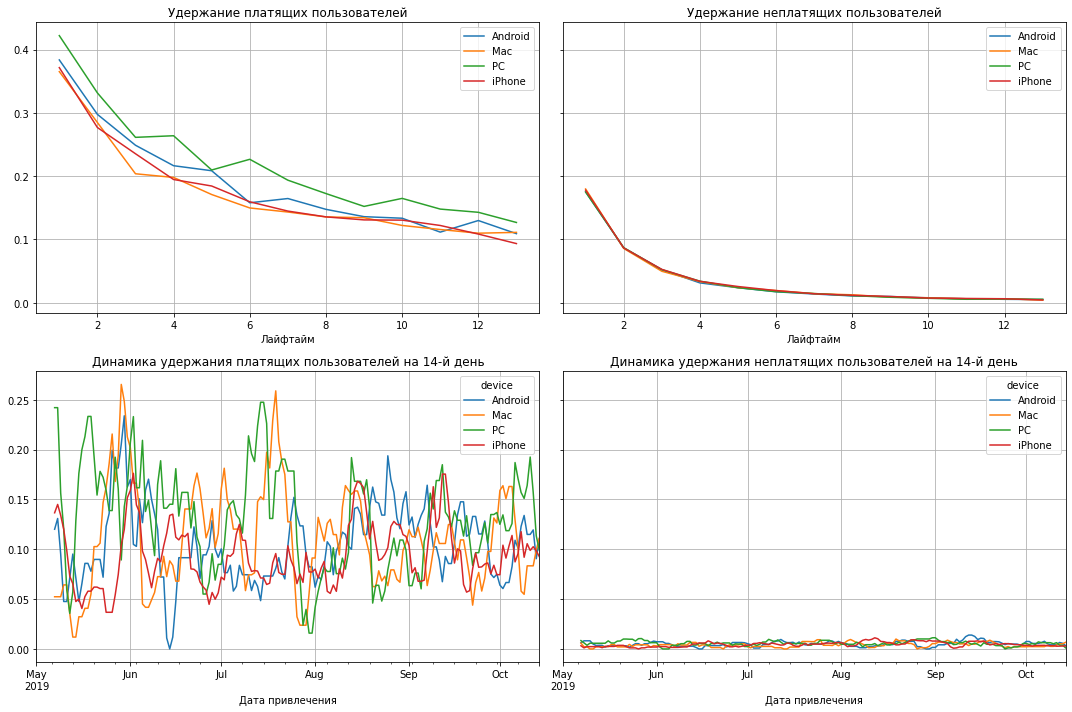

In [73]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Не видно, чтобы пользователи каких-то определенных устройств особо плохо удерживались. Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

**Cмотрим конверсию с разбивкой по странам**

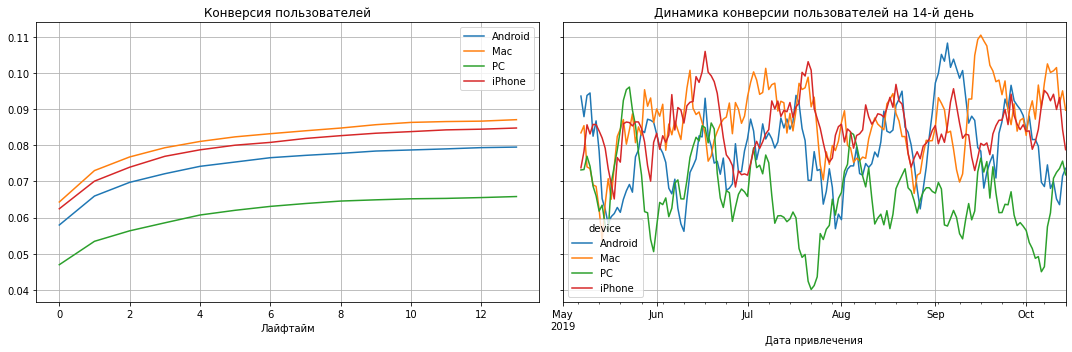

In [74]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Слабая конверсия у пользователей из Англии, Германии и Франции. Но и их доля относительно всех пользователей не такая большая.

**Смотрим удержание с разбивкой по странам**

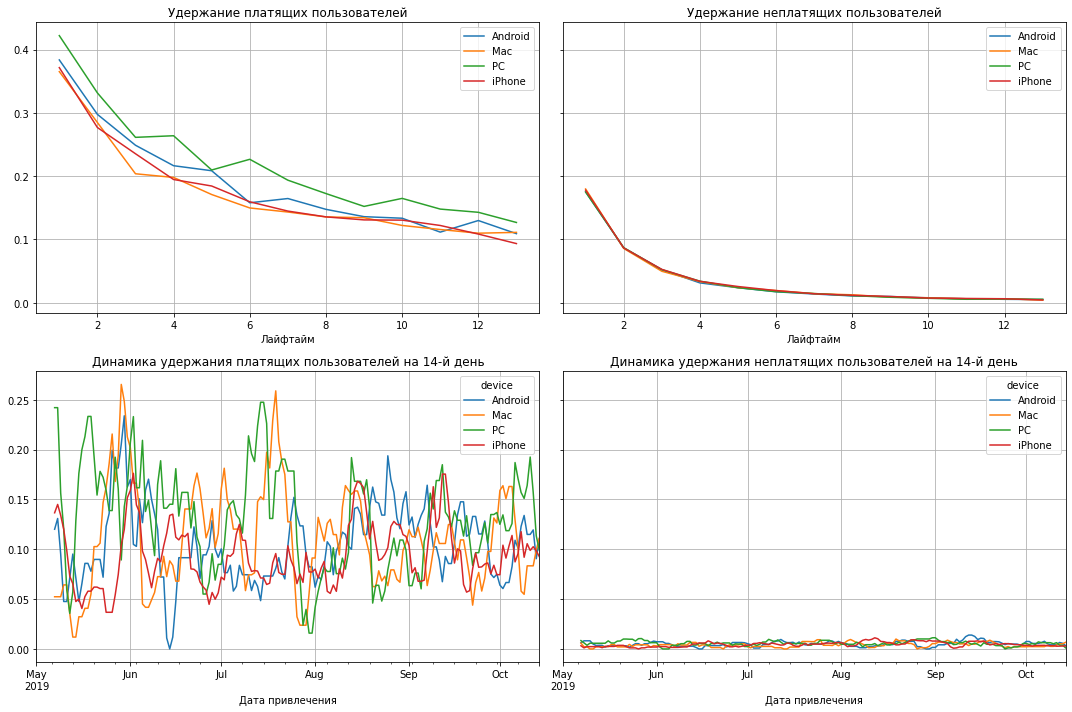

In [75]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Видим, что пользователи из США явно плохо удерживаются.

**Смотрим конверсию с разбивкой по каналам**

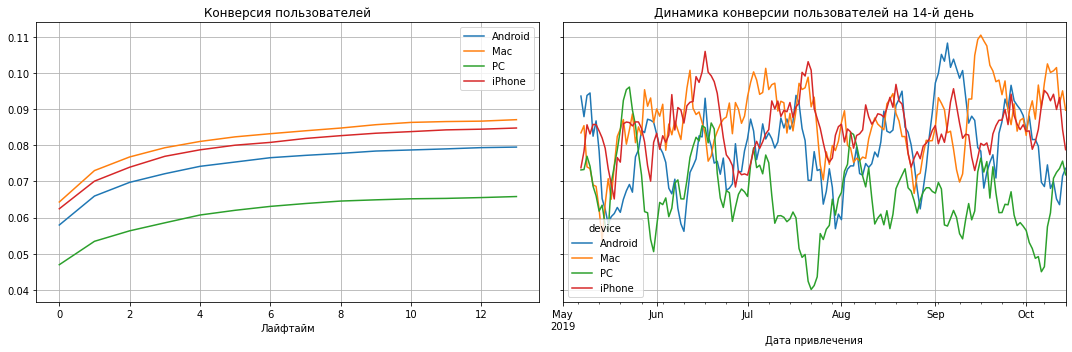

In [76]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Плохо конвертируются пользователи из каналов RocketSuperAds, MediaTornado, YRabbit.

**Смотрим удержание с разбивкой по каналам**

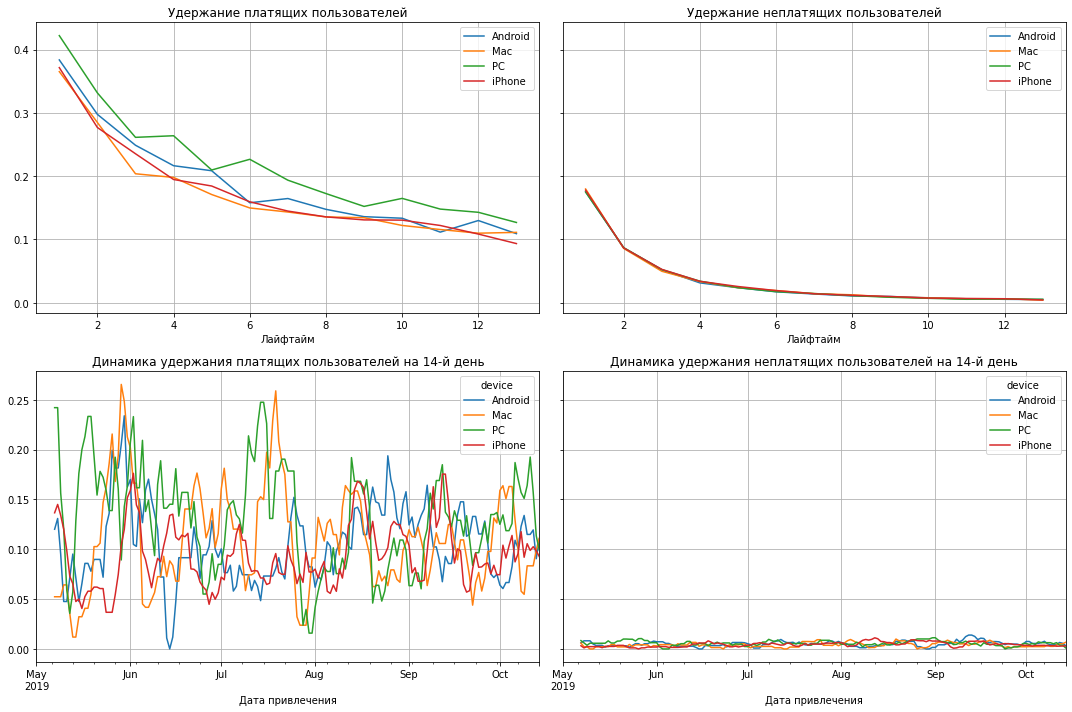

In [77]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Видим явных аутсайдеров - плохо удерживаются пользователи из каналов FaceBoom и AdNonSense.

#### Ответьте вопросы:

##### Окупается ли реклама, направленная на привлечение пользователей в целом?

Реклама не окупается. К концу двух недель ROI на уровне 80%. CAC растет почти все время, причем не плавно, а скачкообразно, то есть рекламные кампании проходят регулярно. LTV стабилен. Значит, пользователи примерно одинакового качества.

##### Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Можно сделать такие выводы:
Реклама не окупается везде, кроме PC и хуже всего окупаются владельцы Mac и iPhone

Если в Европе реклама окупается уже к 6 дню, то в в США не окупается совсем.

Во всех каналах, кроме TipTop, FaceBoom и AdNonSense реклама окупается. CAC растет в TipTop, а в остальных держится стабильно низко и даже немного падает

##### Чем могут быть вызваны проблемы окупаемости?

Проблемы окупаемости могут быть вызваны ненормированным распределением средств на рекламу (в какой-то источник вложено больше средств, чем в остальные, а он не оправдал надежд), также возможно, что горизонт анализа недостаточен для того, чтобы пользователи окупились.

#### Вывод

В целом, реклама близка к окупемости, если учитывать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения и то, что в анализ включены органические пользователи (не будем исключать влияние SEO). Реклама почти окупается к концу 2й недели. ROI — примерно 80% Окупаемость могут снижать владельцы Mac и iPhone, страна - США. Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop. Проблемы окупаемости могут быть вызваны ненормированным распределением средств на рекламу (в какой-то источник вложено больше средств, чем в остальные, а он не оправдал надежд), также возможно, что горизонт анализа недостаточен для того, чтобы пользователи окупились.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

#### Выделите причины неэффективности привлечения пользователей.

Оценена окупаемость рекламы. Рассчитан и визуализирован LTV и ROI. По графикам сделаны следующие выводы:

Реклама не окупается к концу 2й недели. ROI — около 80%. CAC нестабилен. Рекламный бюджет увеличивается с течением времени. На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей. ROI пользователей неумолимо падает. До июля показатель был выше уровня окупаемости, но после стал падать до 0.6. Чтобы разобраться в причинах, мы прошлись по всем доступным характеристикам пользователей — стране, каналу и устройству первого посещения.

Разбивка по устройствам:

Пользователи всех устройств окупались до июня, а потом что-то пошло не так, особенно для владельцев Mac и Iphone. К сентябрю (и какое-то время в августе) ROI пользователей PC на 14 день был на грани окупаемости, ROI всех остальных устройств был уже ниже уровня начиная с июня.

LTV пользователей всё так же подвержен сезонности, но стабилен. Стоимость привлечения пользователей PC самая низкая, а ROI - наоборот, выше остальных. В целом, видим, что стоимость привлечения пользователей всех устройств росла за рассматриваемый период.

Направить внимание следует на владельцев Mac и iPhone - стоимость их привлечения высока (и растет от месяца к месяцу), а окупаемоcть страдает. Посчитана и визуализирована конверсия. Судя по графикам, пользователи Mac, Android и iPhone конвертируются неплохо, причём постоянно. Видимо, дело в удержании. Для проверки удержания использовались функции get_retention() и plot_retention(). Не видно, чтобы пользователи каких-то определенных устройств особо плохо удерживались. Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

Разбивка по странам: Большая доля пользователей - это люди из США (66.66%). Далее идут примерно равные доли пользователей из Англии и Франции (~ 12%). Меньше всего пользователей из Германии (~ 10%) Платящие пользователи из США лидируют (78%), доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%). Платящие пользователи:

Из графики:

* Реклама окупается не везде. В США уровень окупаемости рекламы низкий, а основная аудитория - это пользователи из США при этом стоимость привлечения пользователей из Америки - самая высокая. (Окупаемость пользователей начала падать с конца июня 2019 года.Возможно, неудачный релиз, запуск похожего продукта у конкурентов или какие-то изменения в продукте сыграли отрицательную роль).
* LTV всё так же подвержен сезонности, но стабилен.
* Лучше всего окупается Англия и Германия.

Слабая конверсия у пользователей из Англии, Германии и Франции. Но и их доля относительно всех пользователей не такая большая.

Разбивка по каналам:

* Видим большой рост стоимости привлечения пользователей из рекламного канала TipTop. Достаточно много средств было потрачено на эту рекламную сеть, но выхлопа от нее получилось не так много, как ожидалось.
* Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop.
* Хорошо показала себя рекламная сеть YRabbit в июле - ROI пользователей на 14 день был высок.
* Плохо конвертируются пользователи из каналов RocketSuperAds, MediaTornado, YRabbit.
* Явные аутсайдеры по удерживанию - пользователи из каналов FaceBoom и AdNonSense.

#### Сформулируйте рекомендации для отдела маркетинга.

Хотелось бы выделить владельцев Mac и iPhone и Android - стоимость их привлечения высока (и растет от месяца к месяцу), а окупаемоcть страдает(Больше всего доля платящих пользователей для устройства Mac: 6.36% (1912 человек) из 30042 платят за продукт.Среди пользователей iPhone (54479 человек) доля платящих равна 6.21%. Для пользователей Android (35032 человек) она составляет 5.85%.Среди пользователей PC (30455) платящих меньше всего - 5.05% (1537 человек)). Возможно, стоит рассмотреть какое-то маркетинговое предложение именно для владельцев лидирующих по оплате устройств и баз успешных ОС, чтобы они приносили продукту большую денежную прибыль.

Доли платящих из Франции и Англии примерно равны (7-8%), меньше всего платящих пользователей из Германии (~ 7%), но лучше всего окупается Англия и Германия (среди пользователей из Англии (17575) платящий сегмент составляет 3.98% (700 человек). Примерно такое же соотношение и для пользователей из Франции (3.80% платящих пользователей). Среди пользователей Германии (14981 человека) 616 человек - платящие (это 4.1%)) Возможно, стоит попробовать закупить больше трафика, целясь на эту аудиторию.

Да,платящие пользователи из США лидируют (78%),но и явный аутсайдер по окупаемости - США. Окупаемость пользователей начала падать с конца июня 2019 года и сервис стал менеее привлекательным для пользователей. Стоило бы также выяснить, что могло послужить этому причиной, так как и основная аудитория - это пользователи из США.

Платящие пользователи устройства предпочитаю IPhone (36%) и Android (23%).Среди пользователей iPhone (54479 человек) доля платящих равна 6.21%. Для пользователей Android (35032 человек) она составляет 5.85%. То есть, клиенты больше пользуются мобильными устройствами, чем ПК. Доли PC и Mac практически одинаковы (по 20%). Очевидно что более успешный сегмент так же стоит рассматривать.

Из приритетных каналов с платящими пользователями выделим FaceBoom (12.20%), AdNonSense(11.34%) и lambdaMediaAds(10.47%). (Менее всего конвертируются и интересны пользователи из каналов organic (2.06%), OppleCreativeMedia (2.71%) и LeapBob (3.06%))

Виден достаточный рост стоимости привлечения пользователей из рекламного канала TipTop. Достатьчно много средств было потрачено на эту рекламную сеть, но на выходе получилось не так много, как ожидалось. Возможно, стоит рассмотреть уменьшение бюджета, выделяемого на эту сеть и перенаправление его на более эффективный канал.

Так как не окупаются пользватели, привлеченные из каналов LeapBop, FaceBoom, TipTop (больше всего трафика закупали у TipTop, соответственно к октябрю число трат приближалось к 650 у.е., число трат на FaceBoom находится в районе 300), а остальные каналы привлечения обходятся довольно дешево (хуже всех удерживаются пользователи из каналов FaceBoom и AdNonSense),то стоило бы рассмотреть переключение внимания на более дешевые, но прибыльные каналы.

Так же стоит рассмотреть возможности социальных сетей - так как это динамично развивающийся источник привлечения новых пользователей, имеющий большой охват аудитории и относительно невысокую стоимость.

Окончательные рекомендации:

* Снизить расходы всех девайсов до уровня PC. Т.к. «пожизненная ценность» клиента по этим устройствам почти одинаковы. Хотя у РС ниже, но окупается через 2 недели, в отличии от других.
* Снизить расходы на рекламу в США до уровня других стран.
* Снизить расходы на каналы TipTop, AdNonSense и FaceBoom до уровня 0,5.
* Обратить особое внимание на канал YRabbit - приносит большую прибыль и крайне быстро окупается. Стоит увеличить бюджет.
* Высокую «пожизненная ценность» клиента имеют каналы lambdaMediaAds, WahooNetBanner и RocketSuperAds. Здесь тоже можно увеличить рекламный бюджет.